In [ ]:
import math                      
import matplotlib.pyplot as plt  
import scipy                     
import cv2                       
import numpy as np               
import glob                     
import os                        
import pandas as pd              
import tensorflow as tf       
import itertools
import random
from random import shuffle       
from tqdm import tqdm           
from PIL import Image
from scipy import ndimage
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

##### Uploaded the data on my UTD BOX account, and reading the data through that. (It should be as simple as running the commands below)

In [ ]:
!wget  https://utdallas.box.com/shared/static/6c3syaew1kw37s0zfoimfudztw3fc3nq.zip
import zipfile

with zipfile.ZipFile('6c3syaew1kw37s0zfoimfudztw3fc3nq.zip', 'r') as zip_ref: 
  zip_ref.extractall()

--2022-11-28 23:14:02--  https://utdallas.box.com/shared/static/6c3syaew1kw37s0zfoimfudztw3fc3nq.zip
Resolving utdallas.box.com (utdallas.box.com)... 74.112.186.144
Connecting to utdallas.box.com (utdallas.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/6c3syaew1kw37s0zfoimfudztw3fc3nq.zip [following]
--2022-11-28 23:14:03--  https://utdallas.box.com/public/static/6c3syaew1kw37s0zfoimfudztw3fc3nq.zip
Reusing existing connection to utdallas.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://utdallas.app.box.com/public/static/6c3syaew1kw37s0zfoimfudztw3fc3nq.zip [following]
--2022-11-28 23:14:03--  https://utdallas.app.box.com/public/static/6c3syaew1kw37s0zfoimfudztw3fc3nq.zip
Resolving utdallas.app.box.com (utdallas.app.box.com)... 74.112.186.144
Connecting to utdallas.app.box.com (utdallas.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting 

In [ ]:
train_dir = Path('/content/training')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))
test_dir = Path('/content/validation')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [ ]:
#Creating a DataFrame with the filepath and the labels of the pictures

def proc_img(filepath):
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)

print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

Number of pictures: 1096

Number of different labels: 10

Labels: ['n4' 'n3' 'n5' 'n2' 'n7' 'n0' 'n8' 'n6' 'n1' 'n9']


Filepath Label
0  /content/training/training/n4/n4116.jpg    n4
1  /content/training/training/n4/n4110.jpg    n4
2  /content/training/training/n4/n4029.jpg    n4
3  /content/training/training/n3/n3035.jpg    n3
4  /content/training/training/n5/n5029.jpg    n5

In [ ]:
# Mapping the intitlized name with the orignal name of monkey
name_dic = {'n0':'alouatta palliata', 
            'n1':'erythrocebus patas', 
            'n2':'cacajao calvus', 
            'n3':'macaca fuscata', 
            'n4':'cebuella pygmea', 
            'n5':'cebus capucinus', 
            'n6':'mico argentatus', 
            'n7':'saimiris ciureus', 
            'n8':'aotus nigriceps', 
            'n9':'trachypithecus johnii'}
train_df['Label'] = train_df['Label'].apply(lambda n: name_dic[n])
test_df['Label'] = test_df['Label'].apply(lambda n: name_dic[n])

#### Viewing some contents of data

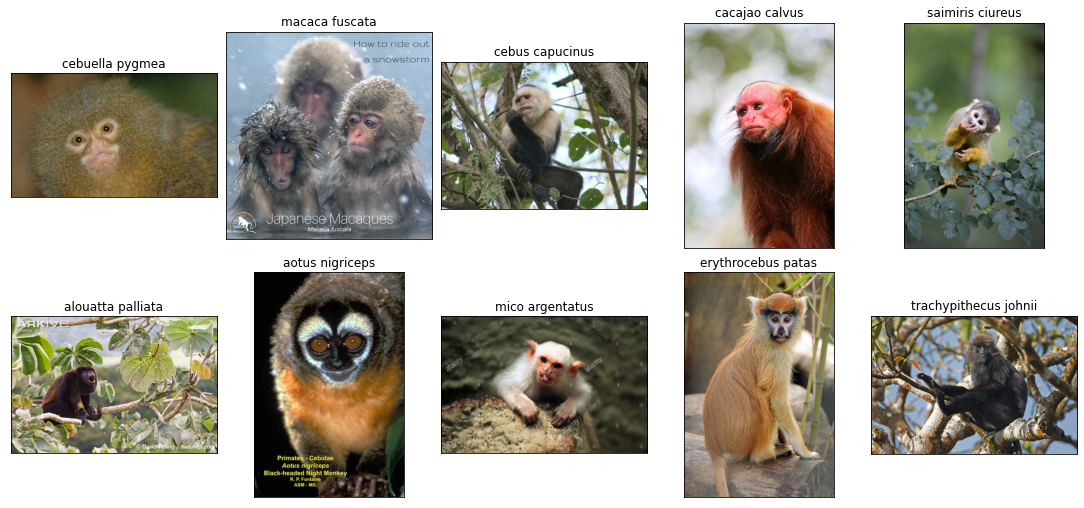

In [ ]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display 10 picture of the dataset
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i])
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
def image_show(num_image,label):
    for i in range(num_image):
        imgdir = Path('/content/training' + label)
        #print(imgdir)
        imgfile = random.choice(os.listdir(imgdir))
        #print(imgfile)
        img = cv2.imread('/content/training'+ label +'/'+ imgfile)
       # print(img.shape)
        #print(label)
        plt.figure(i)
        plt.imshow(img)
        plt.title(imgfile)
    plt.show()

### Using data Augmentation to avoid overfitting, and using MobileNet V2 for transfer learning

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 877 validated image filenames belonging to 10 classes.
Found 219 validated image filenames belonging to 10 classes.
Found 272 validated image filenames belonging to 10 classes.


In [ ]:
# Loading the pre trained MobileNet V2 model, and optimizng the parameters
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)


9406464/9406464 [==============================] - 0s 0us/step


### We can see that this model leads to overfitting because our train and validation accuracy are far apart. 

In [ ]:
# Training the model by tuning the prebuilt model
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
11/28 [==========>...................] - ETA: 12s - loss: 1.2882 - accuracy: 0.5767

KeyboardInterrupt: ignored

In [ ]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

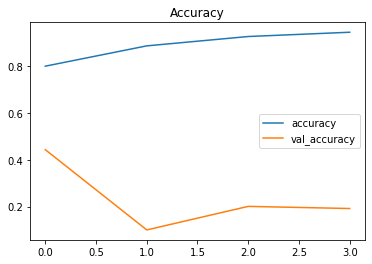

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

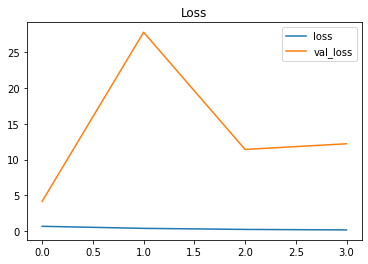

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import optimizers
import pandas as pd
import itertools
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications import MobileNet
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

9/9 [==============================] - 8s 762ms/step
The first 5 predictions: ['cacajao calvus', 'cebus capucinus', 'cebus capucinus', 'trachypithecus johnii', 'macaca fuscata']


In [ ]:
from sklearn.metrics import accuracy_score
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 45.96%


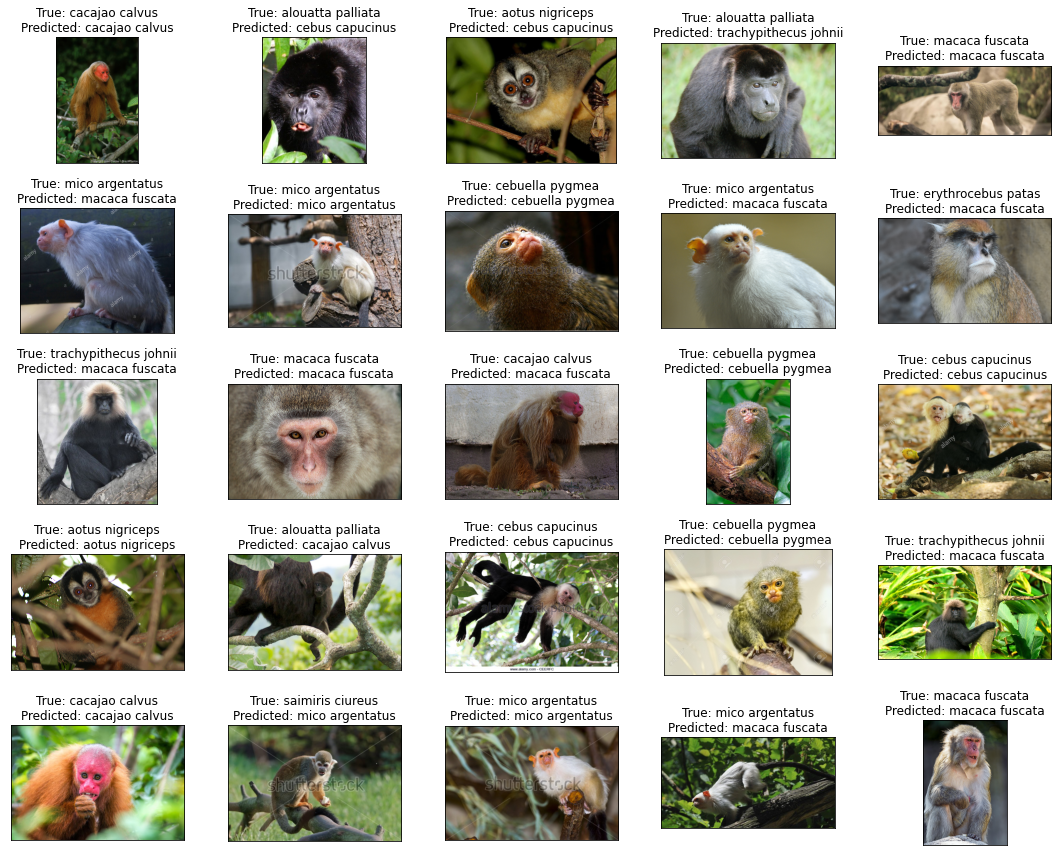

In [ ]:
# Display 36 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}")
plt.tight_layout()
plt.show()

## Now, we will add more layers in our model to increase the complexity and reduce the overfitting overall

In [ ]:
mobile_1 = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3),classes=1000)

for layer in mobile_1.layers:
    layer.trainable = False
    
model_1 = Sequential()
model_1.add(mobile_1)
model_1.add(GlobalAveragePooling2D())
model_1.add(Dense(1024, activation='relu'))
model_1.add(Dense(1024, activation='relu'))
model_1.add(Dense(512, activation='relu'))
model_1.add(Dense(10, activation='softmax'))

print(model_1.summary())

17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                         

In [ ]:
model_1.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [ ]:
history_2 = model_1.fit(train_images, 
                validation_data = val_images,
                   batch_size = 16,
                   epochs = 5,
                   verbose = 1)

## We can see now that validation and training accuracy are closely aligned.

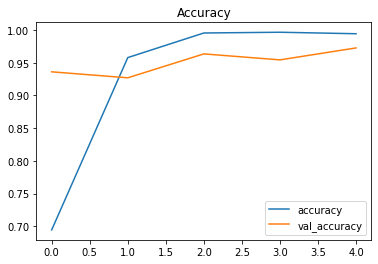

In [ ]:
pd.DataFrame(history_2.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

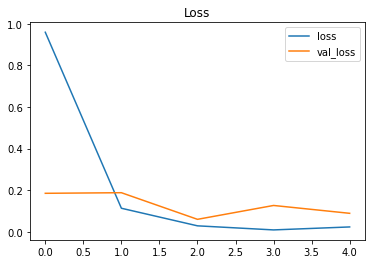

In [ ]:
pd.DataFrame(history_2.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

## Using the model on test dataset

In [ ]:
# Predict the label of the test_images
pred_2 = model_1.predict(test_images)
pred_2 = np.argmax(pred_2,axis=1)

# Map the label
labels_2 = (train_images.class_indices)
labels_2 = dict((v,k) for k,v in labels_2.items())
pred_2 = [labels_2[k] for k in pred_2]

# Display the result
print(f'The first 5 predictions: {pred_2[:5]}')

9/9 [==============================] - 7s 702ms/step
The first 5 predictions: ['cacajao calvus', 'alouatta palliata', 'aotus nigriceps', 'alouatta palliata', 'saimiris ciureus']


In [ ]:
from sklearn.metrics import accuracy_score
y_test_2 = list(test_df.Label)
acc_2 = accuracy_score(y_test_2,pred_2)
print(f'Accuracy on the test set: {acc_2 * 100:.2f}%')

Accuracy on the test set: 96.32%


## Displaying examples of 25 predictions

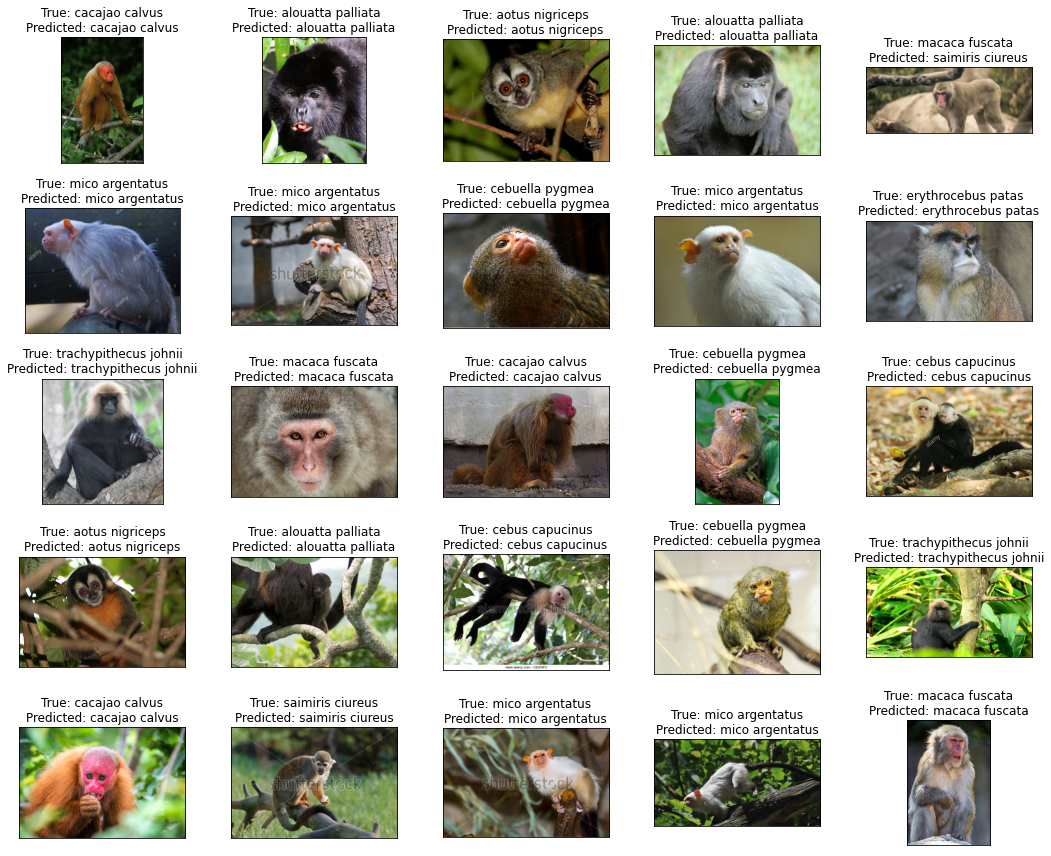

In [ ]:
# Display 36 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred_2[i].split('_')[0]}")
plt.tight_layout()
plt.show()

#### Iteration 2

In [ ]:

mobile_2 = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3),classes=1000)

for layer in mobile_2.layers:
    layer.trainable = False
    
model_2 = Sequential()
model_2.add(mobile_2)
model_2.add(GlobalAveragePooling2D())
model_2.add(Dense(1024, activation='relu'))
model_2.add(Dense(500, activation='relu'))
model_2.add(Dense(10, activation='softmax'))
print(model_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_11 (Dense)            (None, 500)               512500    
                                                                 
 dense_12 (Dense)            (None, 10)                5010      
                                                                 
Total params: 4,795,974
Trainable params: 1,567,110
No

In [ ]:
model_2.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [ ]:
history_3 = model_2.fit(train_images, 
                validation_data = val_images,
                   batch_size = 16,
                   epochs = 5,
                   verbose = 1)

Epoch 1/5
28/28 [==============================] - 28s 957ms/step - loss: 0.8949 - accuracy: 0.7628 - val_loss: 0.1491 - val_accuracy: 0.9543
Epoch 2/5
28/28 [==============================] - 24s 858ms/step - loss: 0.0883 - accuracy: 0.9704 - val_loss: 0.0964 - val_accuracy: 0.9726
Epoch 3/5
28/28 [==============================] - 26s 943ms/step - loss: 0.0344 - accuracy: 0.9909 - val_loss: 0.1112 - val_accuracy: 0.9726
Epoch 4/5
28/28 [==============================] - 27s 990ms/step - loss: 0.0081 - accuracy: 0.9989 - val_loss: 0.0359 - val_accuracy: 0.9954
Epoch 5/5
28/28 [==============================] - 28s 926ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0472 - val_accuracy: 0.9772


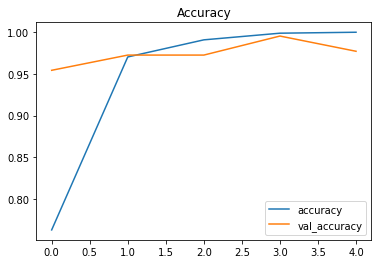

In [ ]:
pd.DataFrame(history_3.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

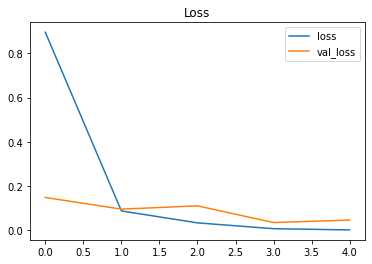

In [ ]:
pd.DataFrame(history_3.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

#### Iteration 3

In [ ]:
# Predict the label of the test_images
pred_3 = model_2.predict(test_images)
pred_3 = np.argmax(pred_3,axis=1)

# Map the label
labels_3 = (train_images.class_indices)
labels_3 = dict((v,k) for k,v in labels_3.items())
pred_3 = [labels_3[k] for k in pred_3]

# Display the result
print(f'The first 5 predictions: {pred_3[:5]}')

9/9 [==============================] - 9s 815ms/step
The first 5 predictions: ['cacajao calvus', 'alouatta palliata', 'aotus nigriceps', 'alouatta palliata', 'cacajao calvus']


In [ ]:
from sklearn.metrics import accuracy_score
y_test_3 = list(test_df.Label)
acc_3 = accuracy_score(y_test_3,pred_3)
print(f'Accuracy on the test set: {acc_3 * 100:.2f}%')

Accuracy on the test set: 96.32%


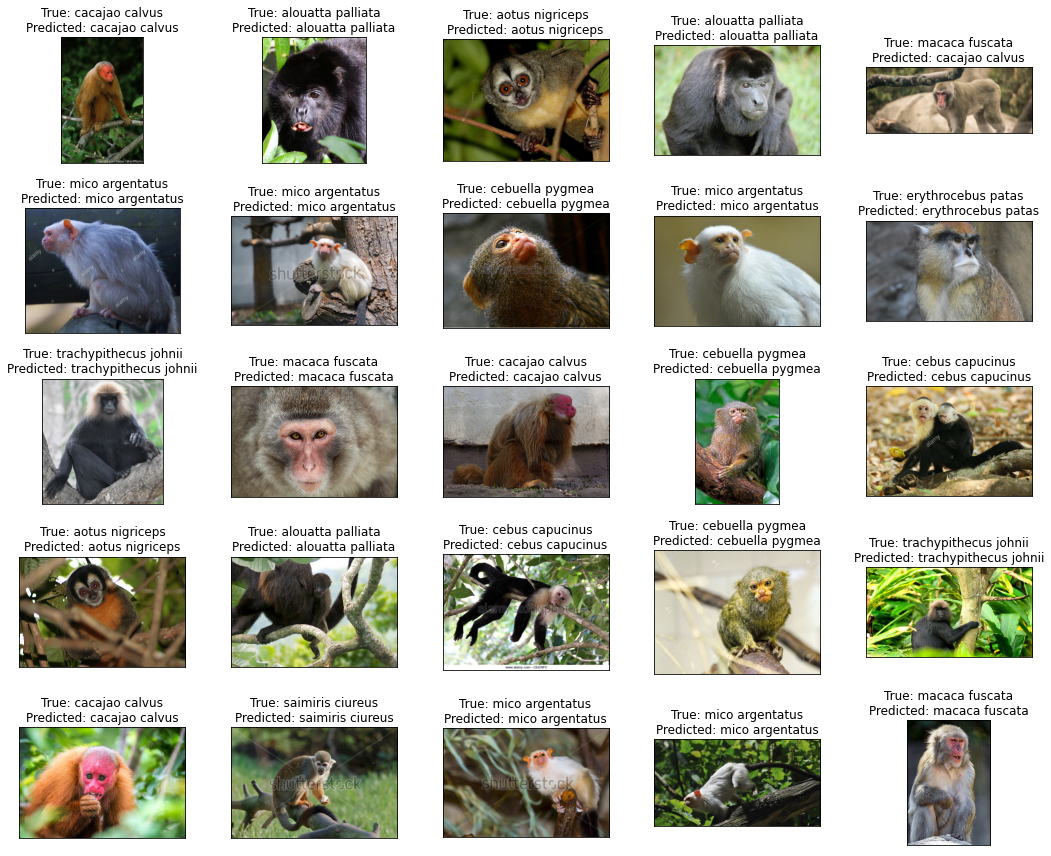

In [ ]:
# Display 36 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred_3[i].split('_')[0]}")
plt.tight_layout()
plt.show()

#### Iteration 4

In [ ]:
mobile_3 = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3),classes=1000)

for layer in mobile_3.layers:
    layer.trainable = False
    
model_3 = Sequential()
model_3.add(mobile_3)
model_3.add(GlobalAveragePooling2D())
model_3.add(Dense(1024, activation='relu'))
model_3.add(Dense(600, activation='relu'))
model_3.add(Dense(10, activation='softmax'))
print(model_3.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_5   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_16 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_17 (Dense)            (None, 600)               615000    
                                                                 
 dense_18 (Dense)            (None, 10)                6010      
                                                                 
Total params: 4,899,474
Trainable params: 1,670,610
No

In [ ]:
model_3.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [ ]:
history_4 = model_3.fit(train_images, 
                validation_data = val_images,
                   batch_size = 16,
                   epochs = 10,
                   verbose = 1)

Epoch 1/10
28/28 [==============================] - 27s 932ms/step - loss: 0.9453 - accuracy: 0.7298 - val_loss: 0.1509 - val_accuracy: 0.9589
Epoch 2/10
28/28 [==============================] - 25s 902ms/step - loss: 0.0964 - accuracy: 0.9726 - val_loss: 0.1670 - val_accuracy: 0.9315
Epoch 3/10
28/28 [==============================] - 23s 843ms/step - loss: 0.0477 - accuracy: 0.9806 - val_loss: 0.0853 - val_accuracy: 0.9680
Epoch 4/10
28/28 [==============================] - 24s 847ms/step - loss: 0.0175 - accuracy: 0.9932 - val_loss: 0.0643 - val_accuracy: 0.9772
Epoch 5/10
28/28 [==============================] - 25s 905ms/step - loss: 0.0142 - accuracy: 0.9954 - val_loss: 0.0717 - val_accuracy: 0.9817
Epoch 6/10
28/28 [==============================] - 24s 833ms/step - loss: 0.0182 - accuracy: 0.9932 - val_loss: 0.0717 - val_accuracy: 0.9863
Epoch 7/10
28/28 [==============================] - 23s 840ms/step - loss: 0.0121 - accuracy: 0.9954 - val_loss: 0.0853 - val_accuracy: 0.9680

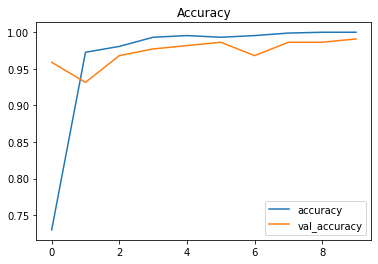

In [ ]:
pd.DataFrame(history_4.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

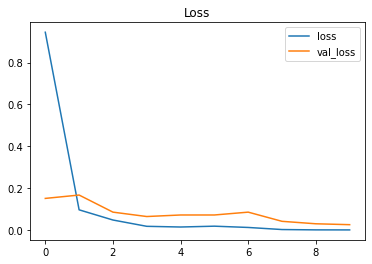

In [ ]:
pd.DataFrame(history_4.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Predict the label of the test_images
pred_4 = model_3.predict(test_images)
pred_4 = np.argmax(pred_4,axis=1)

# Map the label
labels_4 = (train_images.class_indices)
labels_4 = dict((v,k) for k,v in labels_4.items())
pred_4 = [labels_4[k] for k in pred_4]

# Display the result
print(f'The first 5 predictions: {pred_4[:5]}')

9/9 [==============================] - 7s 690ms/step
The first 5 predictions: ['cacajao calvus', 'alouatta palliata', 'aotus nigriceps', 'alouatta palliata', 'cacajao calvus']


In [ ]:
from sklearn.metrics import accuracy_score
y_test_4 = list(test_df.Label)
acc_4 = accuracy_score(y_test_4,pred_4)
print(f'Accuracy on the test set: {acc_4 * 100:.2f}%')

Accuracy on the test set: 97.06%


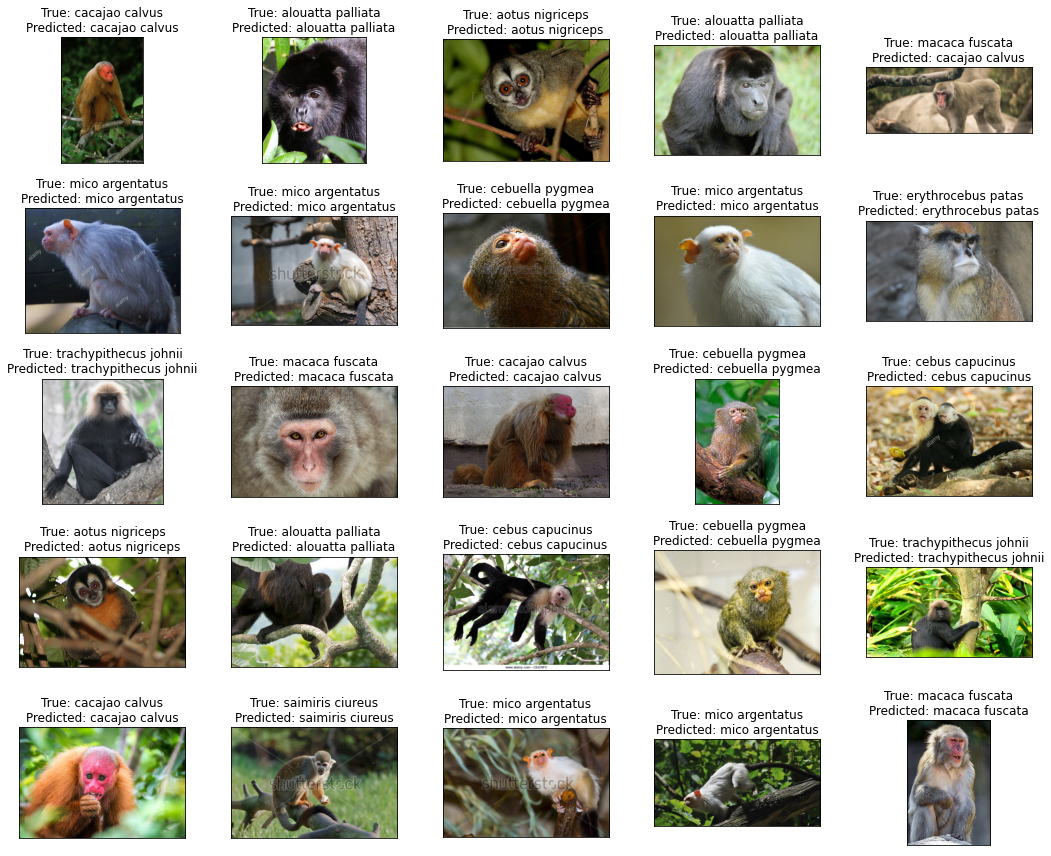

In [ ]:
# Display 36 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred_4[i].split('_')[0]}")
plt.tight_layout()
plt.show()